In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

In [2]:
# Read data
df = pd.read_csv('data/advertising_data.csv')
# Delete strings with ad_chanel = other
df = df[df['ad_channel'] != 'other']
df.head()

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,interest,150000,0.0,Android,banner,0.5
1,897013,interest,150000,0.0,Android,organic_traffic,0.0
2,242700,interest,150000,0.0,Android,organic_traffic,0.0
3,143856,interest,150000,0.0,Android,organic_traffic,0.0
4,26717,consideration,150000,0.0,Android,organic_traffic,0.0


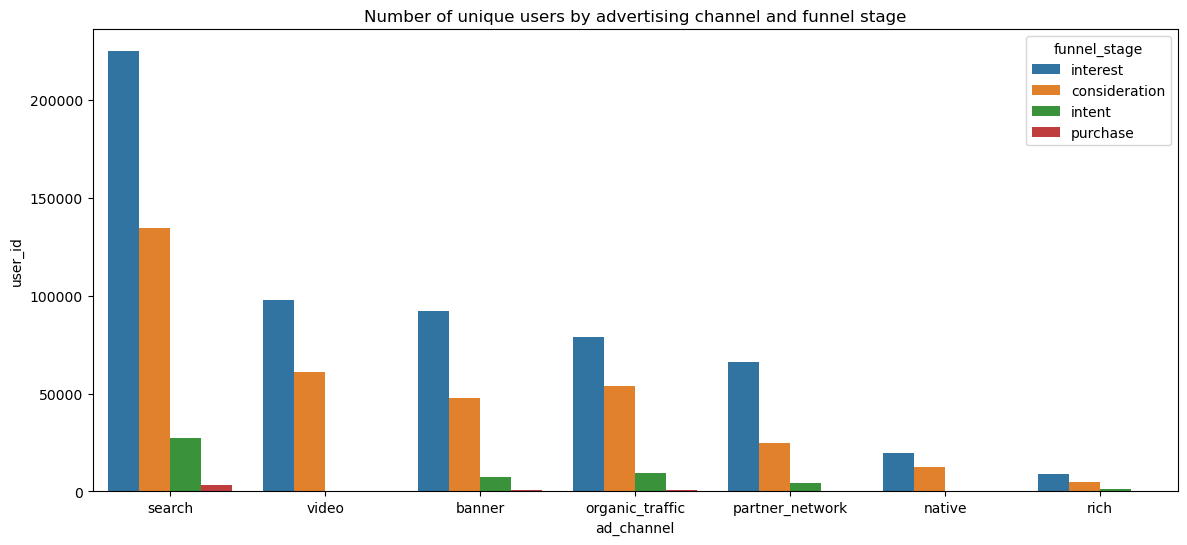

In [3]:
# Number of unique users by advertising channel and funnel stage
df_funnel = df.groupby(['ad_channel', 'funnel_stage']).agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
plt.figure(figsize=(14, 6))

sns.barplot(x='ad_channel', y='user_id', hue='funnel_stage', data=df_funnel)
plt.title('Number of unique users by advertising channel and funnel stage')
plt.show()

# Data Cleaning

Table may contain fraud data. If user performs more than 1 action in the same timestamp, it is considered as fraud.

In [4]:
# How many actions the user performs at one time
df_actions = df.groupby(['user_id', 'timestamp']).agg({'funnel_stage': 'count'}).sort_values('funnel_stage', ascending=False).reset_index()
df_actions.head()

,user_id,timestamp,funnel_stage
0,503272,185866,2
1,562461,177184,2
2,103625,185829,2
3,606357,150830,2
4,657167,207956,2


In [2]:
# Store fraud data to a separate dataframe
fraud = df_actions[df_actions['funnel_stage'] > 1]
fraud_df =  df[df['user_id'].isin(fraud['user_id'])].sort_values('user_id').reset_index(drop=True)
fraud_df

NameError: name 'df_actions' is not defined

In [1]:
# Number of unique users by advertising channel and funnel stage
df_funnel = fraud_df.groupby(['ad_channel', 'funnel_stage']).agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
plt.figure(figsize=(14, 6))

sns.barplot(x='ad_channel', y='user_id', hue='funnel_stage', data=df_funnel)
plt.title('Number of unique users by advertising channel and funnel stage')
plt.show()

NameError: name 'fraud_df' is not defined

In [6]:
print(f'Percentage of fraud users of the total number of users: {round(fraud_df.user_id.nunique() / df.user_id.nunique() * 100, 2)}%')

Percentage of fraud users of the total number of users: 0.82%


In [7]:
# Remove fraud data from the main dataframe
df_new = df[~df['user_id'].isin(fraud['user_id'])].sort_values('user_id').reset_index(drop=True)
df_new

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,2,interest,184320,0.0,iOS,search,1.5
1,3,interest,171761,0.0,iOS,search,1.5
2,4,interest,198271,0.0,Android,organic_traffic,0.0
3,5,consideration,202361,0.0,iOS,organic_traffic,0.0
4,5,interest,197181,0.0,Android,organic_traffic,0.0
...,...,...,...,...,...,...,...
976207,1064747,interest,174322,0.0,Android,organic_traffic,0.0
976208,1064747,consideration,171368,0.0,iOS,organic_traffic,0.0
976209,1064753,interest,166616,0.0,Android,search,1.5
976210,1064759,consideration,168820,0.0,iOS,search,1.5


<Axes: xlabel='timestamp', ylabel='Count'>

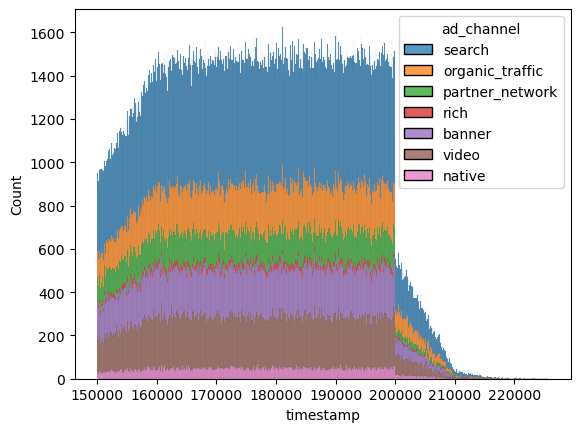

In [8]:
# Number of actions for timestamp by advertising channel
sns.histplot(data=df_new, x='timestamp', hue='ad_channel', multiple='stack', bins=1000)

<Axes: xlabel='timestamp', ylabel='Count'>

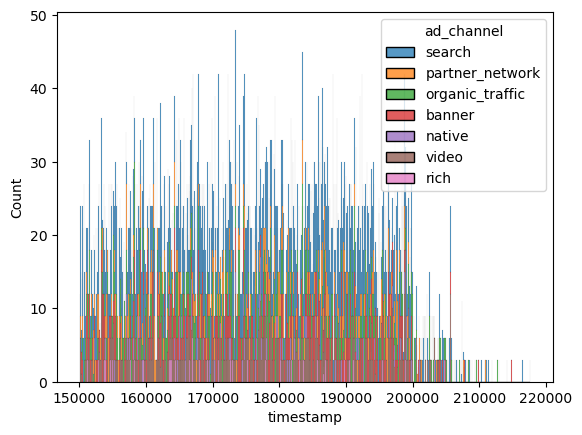

In [9]:
# Number of actions for timestamp
sns.histplot(data=fraud_df, x='timestamp', hue='ad_channel', multiple='stack', bins=1000)

# Correlation Analysis

In [10]:
# Recode values ​​related to the funnel_stage into numbered format
df_new['funnel_stage'] = df_new['funnel_stage'].apply(lambda x: 1 if x == 'interest' else 2 if x == 'consideration' else 3 if x == 'intent' else 4)

# Create dummy variables for ad_channel and os
df_new = pd.get_dummies(df_new, columns=['ad_channel', 'os'], drop_first=True)
df_new.head()

,user_id,funnel_stage,timestamp,profit,price,ad_channel_native,ad_channel_organic_traffic,ad_channel_partner_network,ad_channel_rich,ad_channel_search,ad_channel_video,os_iOS
0,2,1,184320,0.0,1.5,0,0,0,0,1,0,1
1,3,1,171761,0.0,1.5,0,0,0,0,1,0,1
2,4,1,198271,0.0,0.0,0,1,0,0,0,0,0
3,5,2,202361,0.0,0.0,0,1,0,0,0,0,1
4,5,1,197181,0.0,0.0,0,1,0,0,0,0,0


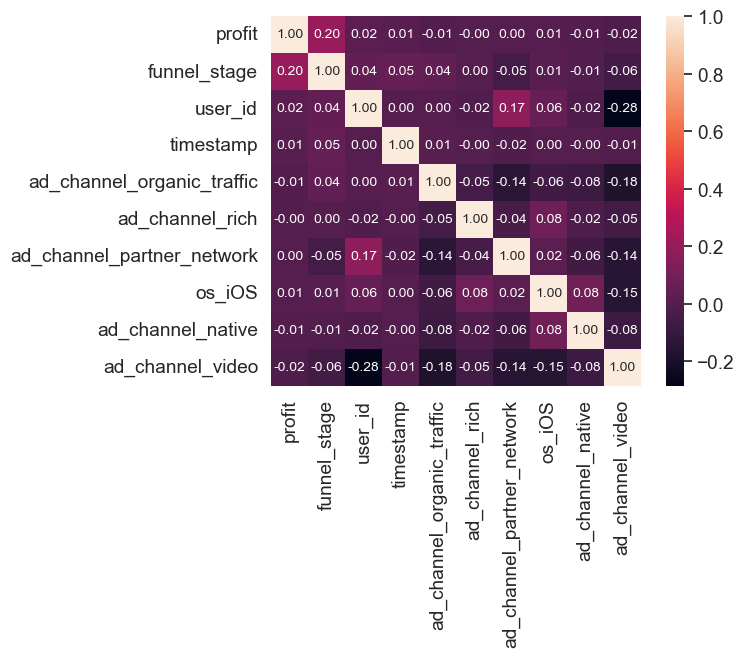

In [11]:
# Apply the factorize method and calculate correlations
corr_matrix = df_new.apply(lambda x: pd.factorize(x)[0]).corr()

# Draw a matrix of correlations 
k = 10 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'profit')['profit'].index
cm = np.corrcoef(df_new[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [12]:
# Correlation of variables with profit
df_new.corr()['profit'].sort_values(ascending=False)

profit                        1.000000
funnel_stage                  0.203903
user_id                       0.023169
ad_channel_search             0.020974
timestamp                     0.014341
price                         0.012991
os_iOS                        0.006300
ad_channel_partner_network    0.004968
ad_channel_rich              -0.002248
ad_channel_organic_traffic   -0.005611
ad_channel_native            -0.006210
ad_channel_video             -0.021625
Name: profit, dtype: float64

# Factor Analysis

<Axes: >

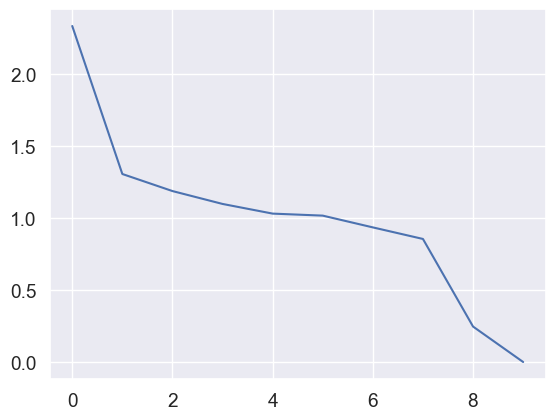

In [16]:
# Perform factor analysis
X = df_new.drop(['user_id', 'profit'], axis=1)
y = df_new['profit']

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

fa = FactorAnalyzer(n_factors=3)
fa.fit(X_sc)

ev, v = fa.get_eigenvalues()
sns.lineplot(data=ev)

In [29]:
n_factors=5

fa = FactorAnalyzer(n_factors=n_factors)
fa.fit(X_sc)

loadings = pd.DataFrame(fa.loadings_, index=X.columns, columns=['factor_{x}'.format(x=x+1) for x in range(n_factors)])

In [43]:
def index(factor, n):
    return loadings[factor].sort_values(ascending=False).index[n]

def value(factor, n):
    return loadings[factor].sort_values(ascending=False).values[n]

# Print the variables with the highest and lowest loadings for each factor
for factor in loadings.columns:
    print(factor)
    highest_index = index(factor, 0)
    highest_value = value(factor, 0)
    lowest_index = index(factor, -1)
    lowest_value = value(factor, -1)
    print('Highest: {index} ({value})'.format(index=highest_index, value=highest_value))
    print('Lowest: {index} ({value})'.format(index=lowest_index, value=lowest_value))
    print('\n')



factor_1
Highest: price (0.9097358173841111)
Lowest: ad_channel_organic_traffic (-0.8574360880996749)


factor_2
Highest: ad_channel_partner_network (1.134575161812554)
Lowest: ad_channel_video (-0.2879482107871956)


factor_3
Highest: ad_channel_native (1.0483644610907386)
Lowest: ad_channel_search (-0.2403068360775039)


factor_4
Highest: ad_channel_search (0.4569418080871861)
Lowest: ad_channel_video (-0.7949234418300056)


factor_5
Highest: ad_channel_rich (1.01358664220979)
Lowest: ad_channel_search (-0.2236660414335678)


